The idea of nn training is this:
* we have a forward pass where take an input and compute an output.
* we have a backward pass where we calculate the gradients of each parameter. We use the chain rule here. Let's say Y is the output of nn.
  Gradient of Y is 1, because Output(Y) = Y. Now let's say we have a variable X that influences Y and Y = f(X), dOutput/dX = dOutput/dY * dY/dX (chain rule) == 1 * dY/dX. And so we can calculate gradients of each parameter, because DAG of dependencies can be topologically sorted. The only trick is that if let's say T influences several parameters P1, P2, ..., then dOutput/dT = sum(dOutput/dP1 * dP1/dT + dOutput/dP2 * dP2/dt + ...), that's the chain rule in multivariable calculus.
* we use gradients to change the values of parameters.
* rinse, repeat

In [39]:
import collections
import math

class Value:
    # `Value` represents, ahem, a value with some additional information
    # for backpropagation to work
    def __init__(self, data, depends_on=None):
        if depends_on is None:
            depends_on = []
            
        self.data = data
        self.grad = 0
        self.depends_on = depends_on
        self._backward = []

    def __add__(self, other):
        other = Value.ensure(other)
        res = Value(
            data=self.data + other.data,
            depends_on=[self, other],
        )
        self.add_backward(lambda: res.grad)
        other.add_backward(lambda: res.grad)
        return res


    def __sub__(self, other):
        other = Value.ensure(other)
        res = Value(
            self.data - other.data,
            depends_on=[self, other],
        )
        self.add_backward(lambda: res.grad)
        other.add_backward(lambda: -res.grad)
        return res

    def __mul__(self, other):
        other = Value.ensure(other)
        res = Value(
            self.data * other.data,
            depends_on=[self, other],
        )
        self.add_backward(lambda: res.grad * other.data)
        other.add_backward(lambda: res.grad * self.data)
        return res

    def __truediv__(self, other):
        other = Value.ensure(other)
        res = Value(
            self.data / other.data,
            depends_on=[self, other],
        )
        self.add_backward(lambda: res.grad / other.data)
        other.add_backward(lambda: res.grad * -self.data / (other.data ** 2))
        return res

    def __pow__(self, other):
        try:
            self.data ** other
        except OverflowError:
            print(f'{self.data=}, {other=}')
        res = Value(
            self.data ** other,
            depends_on=[self],
        )
        self.add_backward(lambda: res.grad * other * (self.data ** (other - 1)))
        return res

    def tanh(self):
        p = 2 * self.data
        res = Value(
            (math.exp(p) - 1) / (math.exp(p) + 1),
            depends_on=[self]
        )
        self.add_backward(lambda: res.grad * (1 - res.data ** 2))
        return res
    
    def backward(self):
        self.grad = 1
        for node in self._iter_topo_sort():
            if node is self:
                continue
            node.calc_gradient()
            
    def calc_gradient(self):
        for f in self._backward:
            self.grad += f()
        
    def _iter_topo_sort(self):
        visited = set()
        nodes = [self]
        in_degrees = collections.Counter({self: 0})
        while nodes:
            node = nodes.pop()
            for dep in node.depends_on:
                in_degrees[dep] += 1
                if dep not in visited:
                    visited.add(dep)
                    nodes.append(dep)
        queue = [node for (node, count) in in_degrees.items() if count == 0]
        assert queue, "can't toposort graph with cycle"
        while queue:
            new_queue = []
            for node in queue:
                yield node
                for dep in node.depends_on:
                    in_degrees[dep] -= 1
                    if in_degrees[dep] == 0:
                        new_queue.append(dep)
            queue = new_queue
            
    def add_backward(self, f):
        self._backward.append(f)

    def __radd__(self, other):
        return self + other

    def __rsub__(self, other):
        return -self + other

    def __rmul__(self, other):
        return self * other

    def __rtruediv__(self, other):
        return (self ** -1) * other

    def __neg__(self):
        return self * -1
    
    def zero_grad(self):
        self.grad = 0
        self._backward = []

    def __repr__(self):
        return f'Value(data={self.data})'

    @staticmethod
    def ensure(data):
        if isinstance(data, (int, float)):
            return Value(data)
        assert isinstance(data, Value), f'{data=} should be an instance of Value'
        return data


def test_value_operations():
    # calculate pi using Leibniz formula
    pi = Value(0.0)  
    for i in range(1000):
        if i % 2 == 0:
            delta = 1.0 / (2 * i + 1)
        else:
            delta = -Value(1.0) / (Value(2) * Value(i) + Value(1))
        pi += delta
    pi *= 4
    print(pi)
    assert math.isclose(pi.data, math.pi, rel_tol=0.001)


test_value_operations()

Value(data=3.140592653839794)


[Value(data=0.5191390550379144)]
loss=Value(data=530.9174651265488)
ys=[-93, -78, -23, 72, 207, 382, 597, 852, 1147, 1482]
pred_ys=[Value(data=-35.8503215085712), Value(data=-43.7535786038154), Value(data=-7.134342212267946), Value(data=74.00738766607115), Value(data=199.67161103120196), Value(data=369.85832788312445), Value(data=584.5675382218385), Value(data=843.7992420473443), Value(data=1147.5534393596417), Value(data=1495.8301301587308)]

loss=Value(data=273776.25014382077)
ys=[-93, -78, -23, 72, 207, 382, 597, 852, 1147, 1482]
pred_ys=[Value(data=454.500001179326), Value(data=454.49999990410356), Value(data=454.4999998985672), Value(data=454.4999998952386), Value(data=454.4999998932325), Value(data=454.49999989202166), Value(data=454.4999998912902), Value(data=454.499999890848), Value(data=454.4999998905807), Value(data=454.4999998904191)]



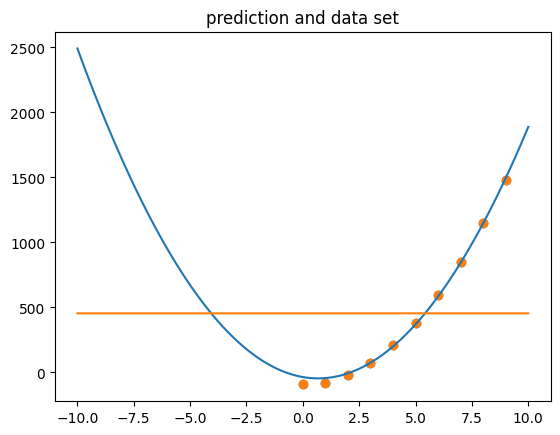

In [102]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

import torch


def pairwise(iterable):
    prev = None
    for i, item in enumerate(iterable):
        if i != 0:
            yield prev, item    
        prev = item


class Neuron:
    def __init__(self, input_size):
        self.weights = [Value(random.uniform(-1.0, 1.0)) for _ in range(input_size)]
        self.bias = Value(0)

    def __call__(self, input_):
        return sum((x * w for (x, w) in zip(input_, self.weights)), self.bias)

    def parameters(self):
        return [*self.weights, self.bias]


class Layer:
    def __init__(self, input_size, output_size, nonlinear=False):
        self.neurons = [Neuron(input_size) for _ in range(output_size)]
        self.nonlinear = nonlinear

    def __call__(self, input_):
        result = [n(input_) for n in self.neurons]
        if self.nonlinear:
            result = [value.tanh() for value in result]
        return result
        
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    def __init__(self, input_size, layer_sizes, nonlinears):
        assert layer_sizes
        self.layers = []
        sizes = [input_size, *layer_sizes]
        i = 0
        for layer_input_size, layer_output_size in pairwise(sizes):
            self.layers.append(Layer(layer_input_size, layer_output_size, nonlinear=nonlinears[i]))
            i += 1

    def __call__(self, input_):
        x = input_
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


def calc_loss(pred_ys, ys):
    return sum((py - y) ** 2 for py, y in zip(pred_ys, ys)) / len(ys)


def item(x):
    assert len(x) == 1
    return x[0]


def test_mlp():
    mlp = MLP(1, (4, 9, 10, 1), [False, False, False, False])
    print(mlp([1, 2, 3]))


def test_grad():
    x = Value(3.0)
    y = Value(4.0)
    for i in range(2):
        x.zero_grad()
        y.zero_grad()
        z = x * y
        z.backward()
        assert x.grad == 4.0, f'{i=}, {x.grad=}'
        assert y.grad == 3.0, f'{i=}, {y.grad=}'
        assert z.grad == 1.0, f'{i=}, {z.grad=}'


class Quad:
    def __init__(self):
        self.w = Value(random.uniform(-1.0, 1.0))
        self.q = Value(random.uniform(-1.0, 1.0))
        self.b = Value(random.uniform(-1.0, 1.0))

    def parameters(self):
        return [self.w, self.q, self.b]

    def __call__(self, x):
        x = item(x)
        return [self.w * (x ** 2) + self.q * x + self.b]


def test_gradient_descent(model, verbose=False):
    xs = range(10)
    ys = [(20 * x ** 2 - 5 * x - 93) for x in xs]
    # mlp =
    num_iter = 10000
    learning_rate = 1e-4
    # gradient descent
    for i in range(num_iter):
        for p in model.parameters():
            p.zero_grad()
        pred_ys = [item(model([x])) for x in xs]
        loss = calc_loss(pred_ys, ys)
        loss.backward()
        for p in model.parameters():
            p.data -= learning_rate * p.grad
        is_last = (i == num_iter - 1)
        if is_last or (verbose and i % 1000 == 0):
            print(f'{loss=}\n{ys=}\n{pred_ys=}\n')
            
    plot_xs = torch.linspace(-10, 10, 100)
    plot_ys = [item(model([x.item()])).data for x in plot_xs]
    plt.scatter(xs, ys)
    plt.plot(plot_xs, plot_ys)
    plt.title('prediction and data set')
    

test_grad()
test_mlp()
test_gradient_descent(Quad())
test_gradient_descent(MLP(1, (3, 3, 1), (True, True, True, True, False, False)))

Here we see that quadratic regression (blue line) does the good job of predicting the data set (orange dots).

MLP (Multi-Layer perceptron, orange line) not so much.